### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [14]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.preprocessing import OneHotEncoder, StandardScaler


VERBOSE = 1
CV = 4 #[(slice(None), slice(None))]
TESTING = True

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [15]:
ITER = 1

hyperparameterspace = {
    'epochs': ["interval-int", 1, 2],
    'batch_size': ["interval-int", 1, 200],
    'learning_rate': ["interval-log", 0.000000001, 1],
    'number_layers': ["interval-int", 1, 2],
    'neurons_per_layer': ["interval-int", 1, 2]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model definition

In [16]:
def relu_advanced(x):
    return K.relu(x)


ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(stddev=0.05, seed=42)


def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                    kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                        kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Optimization

In [17]:
ids = [233211, 359952]  # , 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]

valid_datasets = 0

for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    print("The average value for target is:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    current_dataset_grid = []
    current_dataset_random = []
    current_dataset_bayesian = []
    current_dataset_sparse = []
    current_dataset_sparse_opt = []

    current_dataset_grid_cost = []
    current_dataset_random_cost = []
    current_dataset_bayesian_cost = []
    current_dataset_sparse_cost = []
    current_dataset_sparse_opt_cost = []

    ################## MODEL AND FUNCTION DEFINITION ####################

    def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer):

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        numeric_features = [not x for x in dataset.get_categorical_indicator()]
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(
                    handle_unknown="infrequent_if_exist", sparse_output=False)),
                # ("selector", SelectPercentile(chi2, percentile=50)),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer,
                 dataset.get_categorical_indicator()),
            ]
        )

        for i, (train_index, test_index) in enumerate(split):
            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            preprocessor.fit(X_train, Y_train)

            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)

            regressor = TransformedTargetRegressor(regressor=KerasRegressor(model=create_model,
                                                                            learning_rate=learning_rate,
                                                                            input_dim=len(
                                                                                X_train[0]),
                                                                            number_layers=number_of_layers,
                                                                            neurons_per_layer=neurons_per_layer,
                                                                            verbose=0),
                                                   transformer=StandardScaler())

            regressor.fit(X_train, Y_train, epochs=epochs,
                          batch_size=batch_size)

            Y_predicted = regressor.predict(X_val)
            # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            error = sklearn.metrics.mean_absolute_percentage_error(
                Y_predicted, Y_val)
            values.append(error)

            K.clear_session()

        result = sum(values)/len(values)
        return result

    def blackboxfunction(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = int(params[1])

        learning_rate = params[2]

        number_of_layers = int(params[3])

        neurons_per_layer = int(params[4])
        
        return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer)

    def blackboxfunction_bayesian(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = 10 ** (params[2])

        number_of_layers = int(params[3])

        neurons_per_layer = int(params[4])

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(
                hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
                                                        0], hyperparameterspace_special["learning_rate"][1], x[2])

            number_of_layers = int(HPO.from_standard(hyperparameterspace_special["number_of_layers"][0], hyperparameterspace_special["number_of_layers"][1], x[3]))
           

            neurons_per_layer = int(HPO.from_standard(hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

            return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+3) ** len(hyperparameterspace.keys())

        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("\nPerforming grid search")

        optimization = HPO.GridSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        current_dataset_grid.append(best_score)
        current_dataset_grid_cost.append(cost)

        K.clear_session()

        # ########################### RANDOM SEARCH #######################
        print("\nPerforming random search")

        optimization = HPO.RandomSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        current_dataset_random.append(best_score)
        current_dataset_random_cost.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT #####################
        print("\nPerforming bayesian optimization")

        optimization = HPO.BayesianOptimization(
            dataset, blackboxfunction_bayesian, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                elif hyperparameterspace[key][0] == "interval-log":
                    print(key + ": " + str(10 ** best_params[i]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        current_dataset_bayesian.append(best_score)
        current_dataset_bayesian_cost.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("\nPerforming sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(
            dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=5, adaptivity=0.2, optimizer="gradient_descent")

        result = optimization.fit()

        current_dataset_sparse.append(result[0][1])
        current_dataset_sparse_opt.append(result[0][3])

        current_dataset_sparse_cost.append(result[1])
        current_dataset_sparse_opt_cost.append(result[1]+1)

        K.clear_session()

        print(current_dataset_grid)
        print(current_dataset_random)
        print(current_dataset_bayesian)
        print(current_dataset_sparse)
        print(current_dataset_sparse_opt)

    GRID_RESULT.append(current_dataset_grid)
    RANDOM_RESULT.append(current_dataset_random)
    BAYESIAN_RESULT.append(current_dataset_bayesian)
    SPARSE_RESULT.append(current_dataset_sparse)
    SPARSE_RESULT_OPTIMIZED.append(current_dataset_sparse_opt)

    GRID_COST.append(current_dataset_grid_cost)
    RANDOM_COST.append(current_dataset_random_cost)
    BAYESIAN_COST.append(current_dataset_bayesian_cost)
    SPARSE_COST.append(current_dataset_sparse_cost)
    SPARSE_COST_OPTIMIZED.append(current_dataset_sparse_opt_cost)


######################################################################################################################################################
Current Dataset: 1 of 2 with id: 233211
The average value for target is: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])

################################################## Current Budget: 243 ##################################################

Performing grid search


### Print lines

###################### Current dataset 233211 ######################
Target average: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])
[]


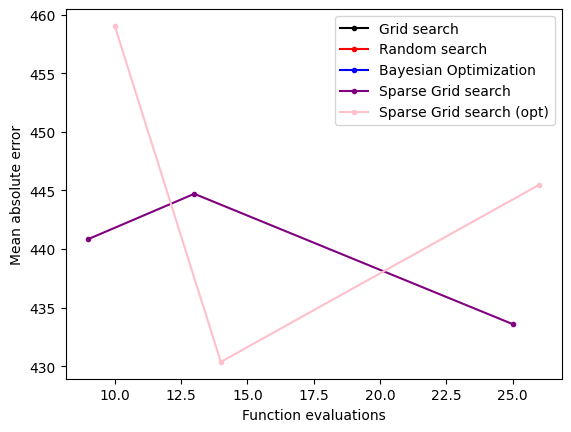

In [ ]:

for i in range(len(ids)):
    print("###################### Current dataset", ids[i], "######################")
    
    dataset = HPO.Dataset(task_id=ids[i])
    
    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    print(GRID_RESULT[i])

    # plotting the points 
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-', color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-', color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-', color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-', color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '.-', color='pink', label="Sparse Grid search (opt)")
    
    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute error')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

### Print points

In [ ]:
# print(GRID_RESULT)
# print(RANDOM_RESULT)
# print(BAYESIAN_RESULT)
# print(SPARSE_RESULT)
# print(SPARSE_RESULT_OPTIMIZED)
# count = 0
# for i in range(len(ids)):
#     print("Current dataset:", i, "with name id:", ids[i])
#     for j in range(ITER):
#         plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
#         plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
#         plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
#         plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
#         plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
#         plt.xlabel("Cost")
#         plt.ylabel("Result (mean squared error)")
#         plt.yscale("log")
#         plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
#         count += 1
#     plt.show()

